In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_curve, 
    auc,
    classification_report
)
from utils.helper import load_and_summarize, split_data, scale_dataframe

In [19]:
df_liver_raw = load_and_summarize('CSV Files/liver_patient.csv')

--- Loading liver_patient.csv ---
First 5 rows:
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  


In [20]:
df_liver = df_liver_raw.drop('Gender', axis=1)
df_liver.dropna(inplace=True)
df_liver['Dataset'] = df_liver['Dataset'].replace(2, 0)

In [21]:
df_liver_scaled = scale_dataframe(df_liver)

In [22]:
X_train, X_test, y_train, y_test = split_data(df_liver_scaled, 'Dataset')

In [23]:
# 1. Logistic Regression Model
log_reg = LogisticRegression(random_state=42,class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

In [24]:
# 2. Decision Tree Classifier Model
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [25]:
# Calculate accuracy for both models
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
acc_tree = accuracy_score(y_test, y_pred_tree)

print(f"Logistic Regression Accuracy: {acc_log_reg:.4f}")
print(f"Decision Tree Accuracy:       {acc_tree:.4f}")

Logistic Regression Accuracy: 0.7328
Decision Tree Accuracy:       0.6466


In [26]:
# --- K-Fold Cross-Validation ---
# Tends to be used for regression problems.
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_results = cross_val_score(log_reg, X_train, y_train, cv=kfold)
print(f"K-Fold CV Scores: {kfold_results}")
print(f"K-Fold Mean Accuracy: {kfold_results.mean():.4f}")

K-Fold CV Scores: [0.64516129 0.56989247 0.66666667 0.57608696 0.56521739]
K-Fold Mean Accuracy: 0.6046


In [27]:
# --- Stratified K-Fold Cross-Validation ---
# Better for classification, as it preserves the percentage of samples for each class.
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skfold_results = cross_val_score(log_reg, X_train, y_train, cv=skfold)
print(f"\nStratified K-Fold CV Scores: {skfold_results}")
print(f"Stratified K-Fold Mean Accuracy: {skfold_results.mean():.4f}")


Stratified K-Fold CV Scores: [0.64516129 0.7311828  0.56989247 0.5326087  0.60869565]
Stratified K-Fold Mean Accuracy: 0.6175


In [28]:
# Check the distribution of classes in the training set
y_train.value_counts()

Dataset
1.0    341
0.0    122
Name: count, dtype: int64

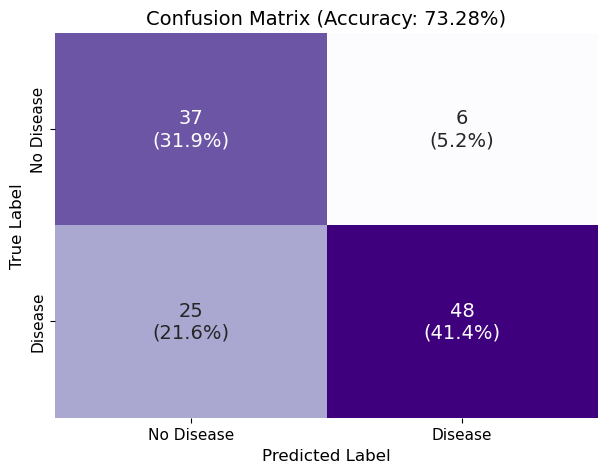

In [32]:
accuracy = accuracy_score(y_test, y_pred_log_reg)
cm = confusion_matrix(y_test, y_pred_log_reg)

# Calculate percentages
cm_percent = cm / np.sum(cm)

# Create string labels combining count and percentage
labels = (
    np.asarray([f"{count}\n({percent:.1%})" for count, percent in zip(cm.flatten(), cm_percent.flatten())])
).reshape(2, 2)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm, 
    annot=labels,           # Use our custom labels
    fmt="",                 # The format is now in our labels, so we leave this empty
    cmap="Purples",         # A visually appealing color map
    cbar=False,             # Disable the color bar for a cleaner look
    annot_kws={"size": 14}  # Increase annotation font size for readability
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2%})", fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=["No Disease", "Disease"], fontsize=11)
plt.yticks(ticks=[0.5, 1.5], labels=["No Disease", "Disease"], va="center", fontsize=11)

plt.show()

In [33]:
print("--- Detailed Classification Metrics (Logistic Regression) ---")
print(classification_report(y_test, y_pred_log_reg, target_names=["No Disease", "Disease"]))

--- Detailed Classification Metrics (Logistic Regression) ---
              precision    recall  f1-score   support

  No Disease       0.60      0.86      0.70        43
     Disease       0.89      0.66      0.76        73

    accuracy                           0.73       116
   macro avg       0.74      0.76      0.73       116
weighted avg       0.78      0.73      0.74       116



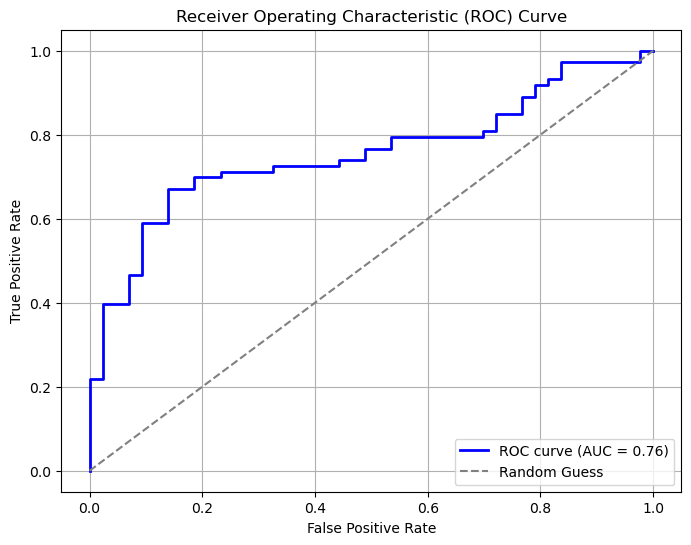

In [34]:
# Predict probabilities for the positive class (Disease)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()